### Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import hessians

### Explanations here

블록 여러개로 더 나누고 설명 적기

In [22]:
# 모델 정의
class LinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        return out


input_dim = 5
output_dim = 1
model = LinearRegression(input_dim, output_dim)

# 손실함수 및 최적화 함수 정의
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [23]:
np.random.seed(2)
num_samples = 1000
num_toxic_samples = 200
x = np.random.rand(num_samples, 5)

y = 2 * x[:, 0:1] + 2 * x[:, 1:2] - 5 * x[:, 2:3] \
    + 1 * x[:, 3:4] - 3 * x[:, 4:5] \
    + 1 + np.random.randn(num_samples, 1)
y[:num_toxic_samples] = - y[:num_toxic_samples] * 10

# Randomly correlate each variables
h = np.random.uniform(size=(5,5))
h[:2, 2:] = 0
x = x @ h / 3
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

## Optimized model for all data

In [24]:
model_1 = LinearRegression(input_dim, output_dim)
criterion_1 = nn.MSELoss()
optimizer_1 = torch.optim.SGD(model_1.parameters(), lr=0.01)

epochs = 10000
for _ in range(epochs):
    y_pred = model_1(x_tensor)
    loss = criterion_1(y_pred, y_tensor)
    optimizer_1.zero_grad()
    loss.backward()
    optimizer_1.step()

initial_weight = model_1.linear.weight.view(-1).detach().numpy()
model_2 = LinearRegression(input_dim, output_dim)
model_2.linear.weight = nn.Parameter(model_1.linear.weight)

In [25]:
reg = 1000
num_iter = 200
num_samples_per_iter = num_toxic_samples // num_iter
sample_indexes_list = np.linspace(0, num_iter*num_samples_per_iter, num_iter+1, dtype=int)[1:]
model_1_weights_list = np.zeros((num_iter, 2))
for i, index in enumerate(sample_indexes_list):
    y_pred = model_1(x_tensor[index:])
    total_loss = criterion(y_pred, y_tensor[index:])
    one_loss = criterion(model_1(x_tensor[index-num_samples_per_iter:index]), y_tensor[index-num_samples_per_iter:index])
    
    one_gradient = hessians.compute_gradient(one_loss, model_1)
    total_hessian = hessians.compute_hessian(total_loss, model_1)
    index_list = [0,1]
    partial_hessian = total_hessian[:, index_list]

    PIF = torch.linalg.inv(partial_hessian.T @ partial_hessian)\
        @ partial_hessian.T \
        @ one_gradient
    PIF /= reg
    PIF = torch.cat((PIF.detach(), torch.zeros(3)))
    m1_weight =  model_1.linear.weight.view(-1)
    w = torch.Tensor(m1_weight + PIF).unsqueeze(0)
    model_1.linear.weight = nn.Parameter(w)
    model_1_weights_list[i, :] = w.view(-1).detach().numpy()[:2]
    
    loss = criterion(model_1(x_tensor), y_tensor)


In [26]:
model_2_weights_list = np.zeros((num_iter, 2))
for i, index in enumerate(sample_indexes_list):
    y_pred = model_2(x_tensor[index:])
    total_loss = criterion(y_pred, y_tensor[index:])
    one_loss = criterion(model_2(x_tensor[index-num_samples_per_iter:index]), y_tensor[index-num_samples_per_iter:index])
    
    one_gradient = hessians.compute_gradient(one_loss, model_2)
    total_hessian = hessians.compute_hessian(total_loss, model_2)
    index_list = [0,1]
    partial_hessian = total_hessian[:, index_list]
    FIF = torch.inverse(total_hessian[:2, :2]) @ one_gradient[index_list]
    FIF /= reg
    FIF = torch.cat((FIF.detach(), torch.zeros(3)))
    m2_weight =  model_2.linear.weight.view(-1)
    w = torch.Tensor(m2_weight + PIF).unsqueeze(0)
    model_2.linear.weight = nn.Parameter(w)
    model_2_weights_list[i, :] = w.view(-1).detach().numpy()[:2]
    loss = criterion(model_2(x_tensor), y_tensor)

In [7]:
search_width = 100
w1_values = np.arange(-search_width, search_width, .5)
w2_values = np.arange(-search_width, search_width, .5)
loss_values = np.zeros((len(w1_values), len(w2_values)))

# 손실값 계산
bias = 1
model.linear.bias = nn.Parameter(torch.Tensor([bias]))
m1_weight =  model_1.linear.weight.view(-1)
for i in range(len(w1_values)):
    for j in range(len(w2_values)):
        w = torch.Tensor([w1_values[i], w2_values[j], m1_weight[2],  m1_weight[3],  m1_weight[4]]).unsqueeze(0)
        model.linear.weight = nn.Parameter(w)
        y_pred = model(x_tensor[num_toxic_samples:])
        loss = criterion(y_pred, y_tensor[num_toxic_samples:])
        loss_values[i][j] = loss.item()

min_index = np.unravel_index(np.argmin(loss_values), loss_values.shape)
map_center = (w1_values[min_index[0]], w2_values[min_index[1]])

In [8]:
np.save('loss_surface.npy', loss_values)

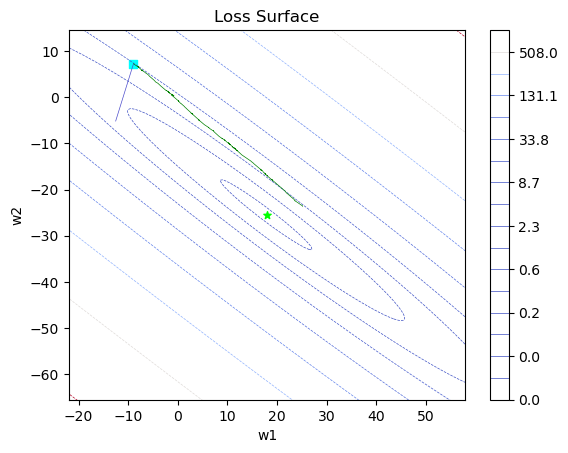

In [14]:
map_length_w1 = 40
map_length_w2 = 40

plt.title("Loss Surface")
plt.xlabel("w1")
plt.ylabel("w2")
plt.xlim(map_center[0] - map_length_w1, map_center[0] + map_length_w1)
plt.ylim(map_center[1] - map_length_w2, map_center[1] + map_length_w2)

# 그래프 그리기
X, Y = np.meshgrid(w1_values, w2_values)
levels = np.logspace(-2, 3, 18, base=10)

cmap = plt.get_cmap('coolwarm') # colormap 지정
plt.contour(X, Y, loss_values.T, levels=levels, 
            cmap=cmap,
            linewidths=.5, linestyles='--')
plt.colorbar()

plt.scatter(map_center[0], map_center[1], s=30, color=(0, 1, 0), marker='*')
plt.scatter(model_1_weights_list[0, 0], model_1_weights_list[0, 1],s=30, color=(0, 1, 1), marker='s')

plt.plot(model_1_weights_list[:, 0], model_1_weights_list[:, 1],
         '-', linewidth=.5, color='green')
plt.plot(model_2_weights_list[:, 0], model_2_weights_list[:, 1],
         '-', linewidth=.5, color=(.3, .3 , .8))

plt.show()

In [10]:
print(torch.linalg.inv(total_hessian))
print(total_hessian)
print(one_gradient)

tensor([[ 1.0791e+03, -1.0710e+03,  5.0016e+03, -3.1091e+03,  4.5026e+03,
         -1.8611e+01],
        [-1.0710e+03,  1.2077e+03, -5.4626e+03,  3.2462e+03, -4.7885e+03,
         -4.8296e+00],
        [ 5.0015e+03, -5.4626e+03,  2.7782e+04, -1.6425e+04,  2.3630e+04,
         -4.0877e+01],
        [-3.1091e+03,  3.2462e+03, -1.6425e+04,  9.9910e+03, -1.4335e+04,
          3.2801e+01],
        [ 4.5025e+03, -4.7886e+03,  2.3630e+04, -1.4335e+04,  2.0828e+04,
         -4.5867e+01],
        [-1.8617e+01, -4.8235e+00, -4.0907e+01,  3.2819e+01, -4.5893e+01,
          8.8605e+00]])
tensor([[0.2664, 0.3168, 0.0692, 0.2307, 0.0970, 0.6997],
        [0.3168, 0.3950, 0.0841, 0.2837, 0.1241, 0.8607],
        [0.0692, 0.0841, 0.0195, 0.0626, 0.0257, 0.1827],
        [0.2307, 0.2837, 0.0626, 0.2150, 0.0936, 0.6170],
        [0.0970, 0.1241, 0.0257, 0.0936, 0.0434, 0.2684],
        [0.6997, 0.8607, 0.1827, 0.6170, 0.2684, 2.0000]])
tensor([-32.3174, -40.3652,  -9.9149, -34.3839, -14.7086, -68.9900])